# Bayesian Statistics for Physicists: 04 Bayesian updating examples

## Contents of the BSFP series

<ul>
    <li><a href="BSFP_01_Overview_and_setup.ipynb">01 Overview and Setup</a>
    <li><a href="BSFP_02_Basics.ipynb">02 Bayesian basics</a>
    <li><a href="BSFP_03_Choosing_priors.ipynb">03 Choosing priors</a>
    <li><a href="BSFP_04_Bayesian_updating.ipynb">04 Examples of Bayesian updating</a>
    <li><a href="BSFP_05_Sampling.ipynb">05 Sampling</a>
    <li><a href="BSFP_06_Model_selection_and_mixing.ipynb">06 Model selection, mixing, ...</a>
    <li><a href="BSFP_07_Gaussian_processes.ipynb">07 Gaussian processes</a>
    <li><a href="BSFP_08_Machine_learning.ipynb">08 Machine learning</a>
    <li><a href="BSFP_A01_Appendices.ipynb">A01 Appendices: reference, vocabulary, notation</a>
</ul>

<hr>

## <a name="Overview">Overview of Bayesian updating examples</a>

$  \newcommand{\thetavec}{\boldsymbol{\theta}}$

Recall Bayes' theorem with $\thetavec$ the vector of parameters we seek and information $I$ is kept implicit.

$$
  \overbrace{p(\thetavec \mid \textrm{data},I)}^{\textrm{posterior}} =
  \frac{\color{red}{\overbrace{p(\textrm{data} \mid \thetavec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{p(\thetavec \mid I)}^{\textrm{prior}}}}
   {\color{darkgreen}{\underbrace{p(\textrm{data} \mid I)}_{\textrm{evidence}}}}
$$

If we view the prior as the initial information we have about $\thetavec$, summarized as a probability density function, then Bayes' theorem tells us how to <em>update</em> that information after observing some data: this is the posterior pdf.  Here we will give some examples of how this plays out in practice.

Last revised: 22-Apr-2019 by Dick Furnstahl [furnstahl.1@osu.edu].
<hr>

## <a name="Contents">Contents of Bayesian updating examples notebook</a> 

<ul>
    <li><a href="#Updating">Bayesian updating examples</a>  
</ul>

<hr>

## <a name="Python">Python/Jupyter set up</a>

See <a href="BSFP_01_Overview_and_setup.ipynb">Part 01</a> for overall installation and setup.

In [9]:
%matplotlib inline   

In [2]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
#plt.style.use('seaborn') # pretty matplotlib plots

import corner
import pymc3 as pm


In [3]:
# make font adjustments
#plt.rcParams['font.size'] = 12
#plt.rcParams['legend.fontsize'] = 'medium'
#plt.rcParams['figure.titlesize'] = 'medium'
plt.rcdefaults()  # revert to defaults for now

In [4]:
%%html  
<!-- Use html cell magic to add css styling -->
<style>
  em {
      color: red;
  }
  dd {
      margin-left: 15px;
  }
  .red{color: red}
  .blue{color: blue}
</style>

## <a name="Updating">Bayesian updating examples</a>

### Determining the bias of a coin

The idea here is that we are observing successive flips of a coin, which is a proxy for any process that has a binary outcome.  There is a definite true probability for getting heads, which we'll label $p_h$, but we don't know what it is.  We start with a preconceived notion of the probability expressed in terms of a prior pdf for $p_h$, i.e., $p(p_h)$.  With each flip of the coin, we have more information, so our goal is to <em>update</em> our expectation of $p_h$, meaning we want the posterior $p(p_h\mid \mbox{# tosses, # heads})$. 

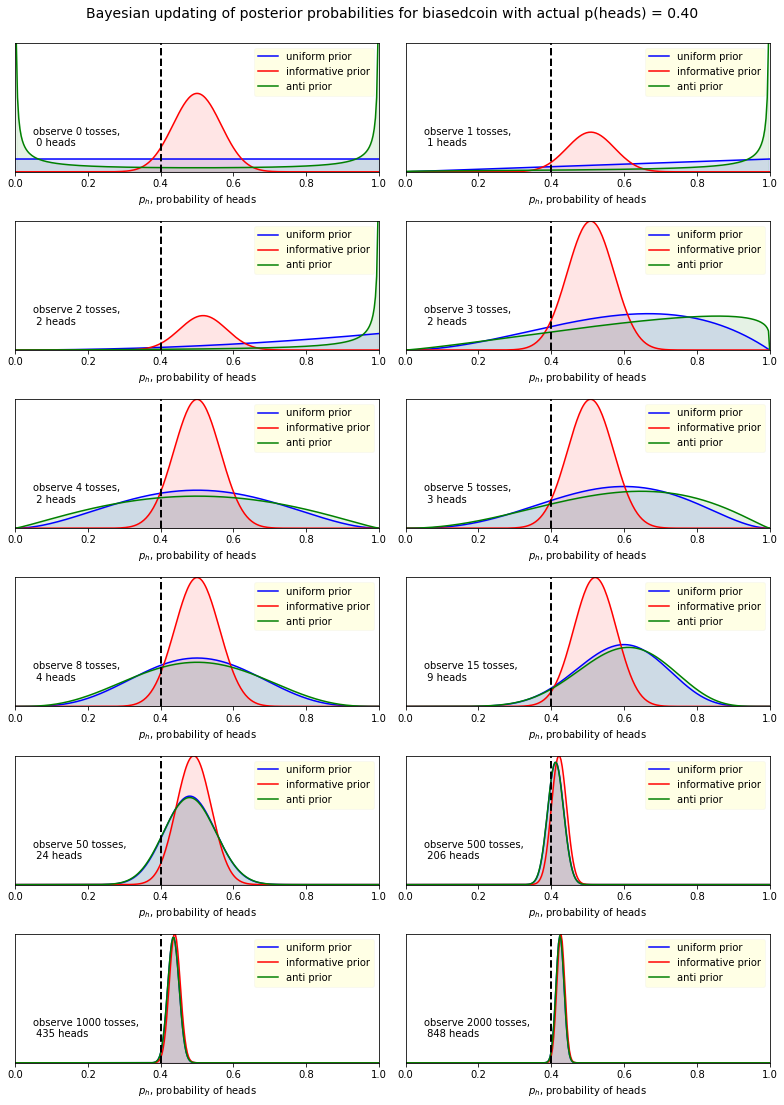

In [8]:
%matplotlib inline
# adapted from  https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats

# If the coin is fair, prob_heads = 0.5 but you can set it to whatever 
#  you want from 0 to 1.
prob_heads = 0.4

# hyperparameters for several different priors
# prior 1 is uniform in [0,1]
alpha_1 = 1
beta_1 = 1
# prior 2 is concentrated near 0.5 with very small tails
alpha_2 = 30
beta_2 = 30
# prior 3 is peaked at ends, but allows for probability everywhere
alpha_3 = .2
beta_3 = .2

# Calculate Bayesian updating using the conjugate prior for binomial, 
#  which is a beta distribution
dist = stats.beta
# n_trials is expected to be a monotonically increasing
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000]  
# data entries are heads or tails, 1 or 0, for independent tosses
data = stats.bernoulli.rvs(prob_heads, size=n_trials[-1])  
# mesh for posterior plots; enough points for pdfs smooth even when narrow
x = np.linspace(0, 1, 301) 

fig = plt.figure(figsize=(11, 2.5*len(n_trials)/2))

# enumerate creates tuple with counter (k) for each n_trials entry (N)
for k, N in enumerate(n_trials):  
    heads = data[:N].sum()   # add up the number of ones = number of heads
    # update using the conjugate prior, which is a beta distribution: 
    #   beta(x,alpha+heads,beta+(N-heads))
    y_1 = dist.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
    y_2 = dist.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = dist.pdf(x, alpha_3 + heads, beta_3 + N - heads)   
    # default y_3 distribution has too-high maximum at endpoints for plot
    y_max = np.max([y_1.max(), y_2.max()])  

    # now make the plots!
    ax = fig.add_subplot(len(n_trials)/2, 2, k+1)  # counter k starts from 0
    ax.set_xlabel("$p_h$, probability of heads") 
    ax.set_yticks([])  # turn off the plotting of ticks on the y-axis
    ax.plot(x, y_1, label="uniform prior", color="blue")
    ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    ax.plot(x, y_2, label="informative prior", color="red")
    ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
    ax.plot(x, y_3, label="anti prior", color="green")
    ax.fill_between(x, 0, y_3, color="green", alpha=0.1)
    ax.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
    ax.annotate("observe {:d} tosses,\n {:d} heads".format(N, heads), 
                xy=(0.05,0.35), xycoords='axes fraction', 
                horizontalalignment='left',verticalalignment='top')
    leg = ax.legend(facecolor='yellow', framealpha=0.1)
    ax.autoscale(tight=True)

figure_title = 'Bayesian updating of posterior probabilities for biased' \
                + f'coin with actual p(heads) = {prob_heads:1.2f}'
fig.suptitle(figure_title,
             y=1.02,
             fontsize=14)

fig.tight_layout()

In [26]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox, Button
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display

# If the coin is fair, prob_heads = 0.5 but you can set it to whatever 
#  you want from 0 to 1.
prob_heads = 0.4

# hyperparameters for several different priors
# prior 1 is uniform in [0,1]
alpha_1 = 1
beta_1 = 1
# prior 2 is concentrated near 0.5 with very small tails
alpha_2 = 30
beta_2 = 30
# prior 3 is peaked at ends, but allows for probability everywhere
alpha_3 = .2
beta_3 = .2

# Calculate Bayesian updating using the conjugate prior for binomial, 
#  which is a beta distribution
dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000]  # this is expected to be a monotonically increasing
data = stats.bernoulli.rvs(prob_heads, size=n_trials[-1])  # heads or tails, 1 or 0, for independent tosses
x = np.linspace(0, 1, 301) # mesh for posterior plots; enough points to make the pdfs smooth even when narrow


def update_plot(index=0):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)

    N = n_trials[index]
    heads = data[:N].sum() 
    y_1 = dist.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
    y_2 = dist.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = dist.pdf(x, alpha_3 + heads, beta_3 + N - heads)   
    y_max = np.max([y_1.max(), y_2.max()])  
    # default y_3 distribution has two high max at endpoints for plot
    
    line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
    ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    line2, = ax.plot(x, y_2, label="informative prior", color="red")
    ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
    line3, = ax.plot(x, y_3, label="anti prior", color="green")
    ax.fill_between(x, 0, y_3, color="green", alpha=0.1)
    
    
    ax.set_xlabel("$p_h$, probability of heads") 
    ax.set_yticks([])  # turn off the plotting of ticks on the y-axis
    ax.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
    ax.annotate("observe {:d} tosses,\n {:d} heads".format(N, heads), xy=(0.05,0.35), 
                     xycoords='axes fraction', horizontalalignment='left',verticalalignment='top')
    leg = ax.legend()
    leg.get_frame().set_alpha(0.4)
    ax.autoscale(tight=True)

 
index_w = IntSlider(value=0, min=0, max=11, step=1,
                    continuous_update=False)
next_button_w = Button(description='Next', disabled=False,
                button_style='', tooltip='Click me')

jump_w = DropDown(description='Jump', disabled=False,)

def update(b):
    index_w.value += 1

next_button_w.on_click(update)
 

plot_out = widgets.interactive_output(update_plot,
                                      dict(
                                           index=index_w,
                                           jump=jump_w,
                                      )
                                     )

hbox_1 = HBox([next_button_w])
UI_box = VBox([hbox_1, plot_out])

display(UI_box)   

### Radioactive decay problem (lighthouse problem)